# TP2

2

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, log
T_MIN = 1
T_MAX = 1000
N = 200
M = 50
t_MIN = 0
t_MAX = 1.5

In [8]:
def T_sampling(n):
    return T_MIN * exp(-(n-1)*(log(T_MIN/T_MAX)/(N-1)))

T = T_sampling(np.arange(N))

3. Display the original signal $\bar{x}$ as a function of $T$ (use log scale on the horizontal axis).

In [11]:
original_signal = np.loadtxt('x.txt')

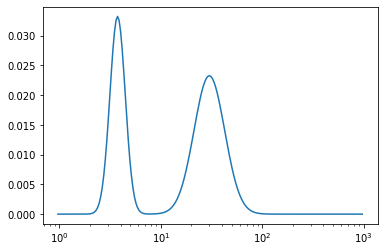

In [16]:
plt.plot(T, original_signal)
plt.xscale('log')
# add axis name

4. Create $t$ using a regular sampling strategy

In [17]:
def t_sampling(m):
    return t_MIN + (m-1)/(M-1) * (t_MAX - t_MIN)
t = t_sampling(np.arange(M))

5. Construct matrix $K$

In [23]:
K = exp(-np.tensordot(T, t, axes = 0))

6. Simulate the noisy data